In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

In [5]:
import evaluate

wer  = evaluate.load('wer')

In [7]:
atco_asr_data = load_dataset('parquet',data_files="validation-00000-of-00002-7a5ea3756991bf72.parquet")

Generating train split: 1013 examples [00:00, 1422.85 examples/s]


# What frequencies are present in the dataset

100%|██████████| 1013/1013 [00:02<00:00, 414.32it/s]


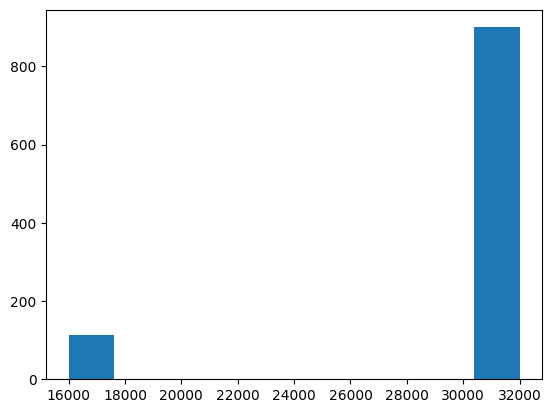

{'audio': {'path': 'LKPR_RUZYNE_Radar_120_520MHz_20201025_140929.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00036621,
          0.00091553,  0.00036621]),
  'sampling_rate': 16000},
 'text': 'Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading(-ding)  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo ',
 'info': 'LKPR\nPraha Ruzyne\nRadar\nAKEVA ARVEG BAGRU BAROX BAVIN BEKVI ELMEK ELPON ERASU EVEMI KENOK KUVIX LETNA RATEV RISUK SOMIS SULOV TIPRU UTORO\nOKLBA PGT302 EZS93AV WZZ9654 TAP1244 QTR8005 PGT1527 DHK547 RYR73AH DLH6YW OKOUU37 AFR10BE RYR2YK SDR4272 OKLLZ TRA6868 UAE139 OKDKB CSA2DZ RRR4941 DEBLN OKPMP LZB301 BRU862 PGT76A OKMHZ RYR2122 DLH4RM OKAVK OKWYZ BLA1RK OKHBT CSA6KG OKXAI04 AFR108Z OKYAI14 RYR5XL UAE140 OKUUR14 OKKEA EWG7AB EWG7677 CSA94D OKSOL OKHSI SFS80 OKTOP  \nOklahoma Alfa Sun Turk Topswiss Wizzair Air Portugal Qatari World Expr

In [ ]:
sr_list=[]
for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
    sample_rate=sample['audio']['sampling_rate']
    sr_list.append(sample_rate)

plt.hist(sr_list)
plt.show()

 As there is 32000Hz is also present in the dataset, we will have to downsample the audio into 16000Hz

In [9]:
from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [11]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [12]:
predictions=[]
references=[]

for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
    audio=sample['audio']['array']
    sample_rate=sample['audio']['sampling_rate']
    text=sample['text']

    audio = down_sample_audio(audio, sample_rate) # downsample the audio to 16000Hz for WHISPER

    input_features = feature_extractor(
    raw_speech=audio,
    sampling_rate=16000,
    return_tensors='pt',
    padding=True).input_features

    # Generate predictions with no gradient computation
    with torch.no_grad():
        op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

    # Decode predictions
    text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

    # Append batch predictions and references to the respective lists
    predictions.extend(text_preds)
    references.extend([text])

    # break


  0%|          | 0/1013 [00:00<?, ?it/s]You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
100%|██████████| 1013/1013 [04:26<00:00,  3.80it/s]


In [13]:
len(predictions),len(references)

(1013, 1013)

In [14]:
wer.compute(predictions=predictions, references=references) * 100

90.40845187588387

In [15]:
text

'algerie two zero seven three proceed direct to trasadingen and continue climb to level two seven zero '

In [16]:
text_preds

[" I'll sherry 2073 Proceed direct to traceting and continue climb to level 270."]